### Overview

This program will search a sequence and attempt to predict PROTEIN CODING genes.  

Steps:  
    1. Get the sequence from FASTA file
    2. Search for start and stop codons
        Defined by [https://www.ncbi.nlm.nih.gov/Taxonomy/Utils/wprintgc.cgi?chapter=cgencodes#SG2]
        * Start: ATA, ATT, ATC, ATG
        * Stop:  TAA, TAG, AGA and AGG
        
    3. Explore various filters to pare down false positives.
        a. ORF length: longer ORFs tend to be genes
        b. GC Content: Protein coding genes tend to have higher GC content than non-coding regions.
        c. Codon Usage Bias / Coding Potential: A probability score based on the frequency of                  codons more often used in protein coding regions than non-coding regions.
    

In [294]:
# Figure size params
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9

In [295]:
# Packages Required
import tabulate as tab
import math
import matplotlib.pyplot as plt
from copy import deepcopy as dc
from matplotlib.ticker import MaxNLocator

In [296]:
# Codon usage for Human MT calculated using:
#Jia W, Higgs PG. Codon usage in mitochondrial genomes: distinguishing context-dependent mutation from translational selection. Mol Biol Evol. 2008;25(2):339-51.
prot_coding_codons = {
    'ttt': '0.069',
    'ttc': '0.139',
    'tta': '0.065',
    'ttg': '0.011',
    'ctt': '0.065',
    'ctc': '0.167',
    'cta': '0.276',
    'ctg': '0.042',
    'att': '0.112',
    'atc': '0.196',
    'ata': '0.165',
    'atg': '0.032',
    'gtt': '0.022',
    'gtc': '0.045',
    'gta': '0.061',
    'gtg': '0.008',
    'tcc': '0.099',
    'tca': '0.081',
    'tcg': '0.007',
    'cct': '0.037',
    'ccc': '0.119',
    'cca': '0.052',
    'ccg': '0.007',
    'act': '0.05',
    'acc': '0.155',
    'aca': '0.132',
    'acg': '0.01',
    'gct': '0.039',
    'gcc': '0.123',
    'gca': '0.079',
    'gcg': '0.005',
    'tat': '0.035',
    'tac': '0.089',
    'taa': '0.004',
    'tag': '0.003',
    'cat': '0.018',
    'cac': '0.079',
    'caa': '0.082',
    'cag': '0.008',
    'aat': '0.029',
    'aac': '0.131',
    'aaa': '0.084',
    'aag': '0.009',
    'gat': '0.012',
    'gac': '0.051',
    'gaa': '0.063',
    'gag': '0.015',
    'tgt': '0.005',
    'tgc': '0.017',
    'tga': '0.09',
    'tgg': '0.009',
    'cgt': '0.006',
    'cgc': '0.026',
    'cga': '0.028',
    'cgg': '0',
    'agt': '0.011',
    'agc': '0.037',
    'aga': '0.001',
    'agg': '0',
    'ggt': '0.016',
    'ggc': '0.087',
    'gga': '0.061',
    'ggg': '0.019',
    'tct': '0.029'


}
    
    


In [297]:
# Gene positions downloaded from BioMart for human and mouse MT
# Used to assess different filtering methods.


#  columns=['GeneID', 'Strand', 'Start', 'Stop','GC']
human_mt_gene_check =  [('ENSG00000198888', 1, 3307, 4262, 47.7), ('ENSG00000198763', 1, 4470, 5511, 42.99),
('ENSG00000198804', 1, 5904, 7445, 46.24),('ENSG00000198786', 1, 12337, 14148, 44.92),
('ENSG00000198712', 1, 7586, 8269, 46.2),('ENSG00000228253', 1, 8366, 8572, 39.61),
('ENSG00000198899', 1, 8527, 9207, 44.2),('ENSG00000198938', 1, 9207, 9990, 46.56),
('ENSG00000198840', 1, 10059, 10404, 40.17),('ENSG00000212907', 1, 10470, 10766, 43.1),
('ENSG00000198886', 1, 10760, 12137, 44.27),('ENSG00000198695', -1, 14149, 14673, 42.67),
('ENSG00000198727', 1, 14747, 15887, 46.28)]

# columns = ['GeneID', 'Strand', 'Start', 'Stop', 'GC']
mouse_mt_gene_check = [('ENSMUSG00000064341', 1, 2751, 3707, 37.62), ('ENSMUSG00000064345', 1, 3914, 4951, 35.74),
('ENSMUSG00000064351', 1, 5328, 6872, 39.87), ('ENSMUSG00000064354', 1, 7013, 7696, 38.6),
('ENSMUSG00000064356', 1, 7766, 7969, 31.86), ('ENSMUSG00000064357', 1, 7927, 8607, 35.98),
('ENSMUSG00000064358', 1, 8607, 9390, 38.9), ('ENSMUSG00000064360', 1, 9459, 9806, 33.05),
('ENSMUSG00000065947', 1, 9877, 10173, 41.08), ('ENSMUSG00000064363', 1, 10167, 11544, 35.63),
('ENSMUSG00000064367', 1, 11742, 13565, 37.12), ('ENSMUSG00000064368', -1, 13552, 14070, 34.1),
('ENSMUSG00000064370', 1, 14145, 15288, 39.07)]


## Sequence Manipulation
***

In [298]:
# Given a fasta file return the contained sequence.

# Input:
#   A path to a FASTA format file (eg r'C:/Users/Mike/data/human_mt.fa')
# Output:
#   A Single nucleotide Sequence as a string.
# Notes:
# Only accept FASTA (uncompressed files), support for more files could be added.

def read_seq_fasta(file):
    with open(file, 'r') as f:
        # Skip > line
        next(f)
        ret_seq = f.read().replace('\n', '')
        ret_seq = str.lower(ret_seq)

    return(ret_seq)


In [299]:
# Generate the reverse compliment of the handed in sequence
# Input:
#   Single nucleotide Sequence
# Output:
#   A single nucleotide sequence that is the reverse compliment of the input sequence.


def rev_comp(seq):
    # Dictionary to flip letters
    comp_dict = {'a': 't',
            'c': 'g',
            'g': 'c',
            't': 'a',
            'n':'n'}
    rev = ''
    for i in range(0, len(seq)):
        rev += comp_dict[seq[i]]
    return rev[::-1]


## ORF search
***

In [300]:
# Find all ORFs in a sequence. 
# Input:
#   Single nucleotide Sequence.
#   List of start codons to use.
#   List of stop codons to use.
# Output:
#   List of ORFs found in the input sequence.

def findORFs(seq, starts, stops):
    # List of our identified orfs that we will work on.
    orfs = []

    # Location of start codons found.
    start_locs = []

    # Loop over the whole seq looking for start codons
    for i in range(len(seq) - 2):
        # If the nucleotides between i and i+3 (NNN) = ATG its a start
        if seq[i:i + 3] in starts:
            start_locs.append(i)

    # Loop through our starting indices and define ORFs by finding stop codons
    for i in start_locs:
        # No need to look at start codon.
        loc = i + 3
        while loc < (len(seq) - 2):
            codon = seq[loc:loc + 3]
            if codon in stops:
                # Found a stop
                orfs.append(seq[i:loc + 3])
                break
            # Move to next codon
            else:
                loc += 3
    return(orfs)


## Helper Functions
***

In [301]:
# Calculate GC content for a given ORF sequence
# Input:
#   Single nucleotide Sequence
# Output:
#   A GC content value for the input sequence.

def calcGC(seq):
    gc = seq.count('g')
    gc += seq.count('c')
    return(gc / len(seq))


In [302]:
# Calculate codon usage over a given seq.
# Input:
#   Single nucleotide Sequence
# Output:
#   A normalize probability value (score) calculated for the input sequence.
# Notes:
# The score will be calculated simply by multiplying the probability of each
# codon defined in "prot_coding_codons"

def calc_codon_bias(seq):
    prob = 1
    loc = 0
    # count codons
    ct = 0
    while loc < (len(seq) - 2):
        ct += 1
        codon = seq[loc:loc + 3]
        if 'n' in codon:
            loc += 3
            continue

        prob *= float(prot_coding_codons.get(codon))
        loc +=3

    # protein coding bias calculated above divided by random prob
    # of codons appearing
    rand = pow(0.015625, ct)
    ret = prob / rand
    
    if(ret == 0):
        ret = 1
     
    log = math.log10(ret)

    return log


## Scoring Functions
***

In [303]:
# Score the orfs by codon usage bias.  
# Input:
#   List of ORFs
#   Window Size: a chunk size to break the sequence into
#   Codon Usage Bias score cutoff.

# Output:
#   List of ORFs with a codon usage bias score above the input threshold

def bias_score(orfs, window = 120, score_cut = 10):
    # Cycle through each ORF and calculate a probability.
    # Average windows together over an entire orf to get a final score.
    ret = []

    for curr in orfs:
        seq = curr[4]
        chunks = [seq[i:i + window] for i in range(0, len(seq), window)]
        probs = []
        for f in chunks:
            cb = calc_codon_bias(f)
            norm = len(f) / len(seq)
            probs.append(cb * norm)

        avg = sum(probs) / len(probs)
        # If our avg bias is above the scoring threshold add
        # this orf to return list.
        if avg >= score_cut:
            ret.append(curr)

    return ret

In [304]:
# Filter the orfs by GC content. 
# Input:
#   List of ORFs
#   GC lowerbound

# Output:
#   List of ORFs that have a GC content higher than lower bound

def gc_filter(orfs, gc_low = 0.35):
    ret = []
    for i in orfs:
        gc = calcGC(i[4])
        if gc > gc_low:
            ret.append(i)

    return ret

In [305]:
# Filter the orfs by ORF length. 
# Input:
#   List of ORFs
#   Length lowerbound

# Output:
#   List of ORFs that have a Length higher than lowerbound

def len_filter(orfs, len_cut = 150):
    return [i for i in orfs if len(i[4]) >= len_cut]

## Assessment
***

In [306]:
# Compare list of ORFs to the genes as defined by Ensembl (via BioMart)
# Input:
#   List of ORFs
#   Organism

# Output:
#   Calculated statistics:
#   tp: The number of predicted ORFs matching genes identified by Ensembl.
#   tpr: True Positive Rate (# True Pos / Total condition Postive).
#   fp: The nukmber of predicted ORFs NOT in the genes identifed by Ensembl.
#   fdr: False disovery rate (# False Positives / (# False Positives + # True Positives)


def check(orfs, org = "human"):
    # Set our true gene set from Ensembl
    if org == "human":
        tests = human_mt_gene_check
    elif org == "mouse":
        tests = mouse_mt_gene_check
    else:
        tests = human_mt_gene_check


    total_genes = len(tests)

    # Collect our stats
    # True positive: Gene is in both ORF list and test set of actual genes
    tp = 0
    tp_list = []

    # False Positive: My algo calls gene but this isn't a real gene
    fp = 0
    fp_list = []
    
    # Catch duplicates and skip so we don't count the same gene 2x.
    dupes = []


    # NEED SOME WIGGLE ROOM on stop index (1 of mine was +1, 1 was +2, rest were 0)
    # Not sure what's causing that, very odd that it would differ on only 2.
    # Left in wiggle room for start

    # Loop through orfs searching for sequences in test
    for curr in orfs:
        start_low = curr[1] - 3
        start_high = curr[1] + 3
        stop_low = curr[2] - 3
        stop_high = curr[2] + 3
        seq = curr[4]

        for x in tests:
            if ( (x[2] >= start_low and (x[2] <= start_high) ) and
                    ( (x[3] >= stop_low) and (x[3] <= stop_high))):
                # found a dupe, skip it.
                if x[0] in dupes:
                    continue
                else:
                    dupes.append(x[0])
                    tp += 1
                    tp_list.append(curr)
                   
    # Sensitivity / True Positive Rate
    tpr = tp / total_genes
    fp = len(orfs) - tp
    if (len(orfs) == 0):
        spec = 0
    else:
        spec = tp / len(orfs) 
    if (fp == 0) and (tp == 0):
        fdr = 0
    else:
        fdr = fp / (fp + tp)
    return (tp, tpr, fp, fdr, total_genes, spec)

In [307]:
# Sweep through our different testing params and output results in tabular and graphical form.
# This should help find the optimal values for each filter.
# Input:
#   List of ORFs
#   Organism
#   List of start codons that were used to define ORFs
#   List of stop codons that were used to define ORFs

# Output:
#   A table of statistics for the tested paramte:
#     Filter: The filters applied to obtain this result.
#     ORFs Discovered: The number of ORFs found in the input sequence after filtering.
#     Ensembl Genes: The number of genes idenified by Ensembl.
#     True Pos: The number of predicted ORFs matching genes identified by Ensembl.
#     Sens: Sensitivity(# True Pos / Total condition Postive).
#     Spec: Specificity (# TP / Total # of ORFs found)
#     False Pos: The nukmber of predicted ORFs NOT in the genes identifed by Ensembl.
#     FDR: False disovery rate (# False Positives / (# False Positives + # True Positives).
#  Plots for each parameter being examined (different values on x-axis):
#     Top plot: plots FDR and TPR on 1st y-axis and # of ORFS sound on 2nd y-axis
#     Bottom plot: plots true positives found on y-axis

# Notes:
# Currently testing the following parameters:
#      Length: 120bp - 500bp in increments of 5bp.
#      GC Content: 25% - 75% in increments of 1%.
#      Codon Usage Bias: 1 to 50 in increments of 1.



def testing(orfs, starts, stops, org = "human"):

    print("Filter: The filters applied to obtain this result.\n"
          "ORFs Discovered: The number of ORFs found in the input sequence after filtering.\n"
          "Ensembl Genes: The number of genes idenified by Ensembl.\n"
          "True Pos: The number of predicted ORFs matching genes identified by Ensembl.\n"
          "TPR: True Positive Rate (# True Pos / Total condition Postive).\n"
          "False Pos: The nukmber of predicted ORFs NOT in the genes identifed by Ensembl.\n"
          "FDR: False disovery rate (# False Positives / (# False Positives + # True Positives).\n")

    # Get our baseline from our orfs
    tmp = check(orfs, org)
    # Results format:
    # Filter | ORF count | TPRate  | FN Rate | FP Rate
    results = [('None', len(orfs), tmp[4], tmp[0], tmp[1], tmp[5], tmp[2], tmp[3])]


    # Deep copies of lists so we can filter them independently
    len_orfs = dc(orfs)
    gc_orfs = dc(orfs)
    codon_orfs = dc(orfs)
    hex_orfs = dc(orfs)

    # Setup text for plots
    organism = 'Org: ' + str(org)
    start_codons = 'Start Codons: ' + ', '.join(starts)
    stop_codons = 'Stop Codons: ' + ', '.join(stops)
    text = organism + "\n" + start_codons + "\n" + stop_codons


    ######################################
    ########### LEN Search ###############
    ######################################
    print("\n\n================================================================")
    print("Varying Minimum ORF Length")
    print("================================================================\n\n")
    
    plot_len = []
    plot_orfs = []
    plot_tpr = []
    plot_fdr = []
    plot_tp = []
    plot_spec = []
    plt.figure(1)

    # change up length filter
    for x in range(120, 510, 5):
        orfs = len_filter(len_orfs, x)
        tmp = check(orfs, org)
        filt = 'Length >= ' + str(x)
        results.append((filt,  len(orfs), tmp[4], tmp[0], tmp[1], tmp[5], tmp[2], tmp[3]))
        plot_len.append(x)
        plot_orfs.append(len(orfs))
        plot_tpr.append(tmp[1])
        plot_fdr.append(tmp[3])
        plot_tp.append(tmp[0])
        plot_spec.append(tmp[5])


    y1 = range(0,1)
    ax1 = plt.subplot(211)
    tp = plt.subplot(212)

    ax2 = ax1.twinx()
    p1 = ax1.plot(plot_len, plot_tpr, linewidth=2.0, label = 'Sensitivity', color = 'C0')
    p2 = ax1.plot(plot_len, plot_spec,  linewidth=2.0, label = 'Specificity', color = 'C1')
    p3 = ax2.plot(plot_len, plot_orfs,linewidth=2.0, label = "# ORFs", color = 'C2')
    ps = p1 + p2 + p3
    labs = [lab.get_label() for lab in ps]
    ax1.legend(ps, labs, loc = 'center right')
    ax1.set_xlabel('Min Length of ORFs')
    ax2.set_ylabel('# of ORFs', color='g')

    
    # TP plot
    p4 = tp.plot(plot_len, plot_tp, linewidth=2.0, label = 'True Positives', color = 'C3' )
    tp.legend(p4, (p4[0].get_label(),), loc = 'upper right')
    tp.set_xlabel("Min Length of ORFs")
    tp.set_ylabel("True Positive Genes Found")
    tp.set_ylim(0,13)
    tp.set_title(text)

    tp.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()


    ######################################
    ########### GC  Search ###############
    ######################################
    gc_range = range(10, 60, 1)

    print("\n\n================================================================")
    print("Varying Minimum ORF GC Content")
    print("================================================================\n\n")
    
    plot_len = []
    plot_orfs = []
    plot_tpr = []
    plot_fdr = []
    plot_tp = []
    plot_spec= []
    # GC
    plt.figure(2)
    #Change up GC filter
    for x in gc_range:
        orfs = gc_filter(gc_orfs, x/100)
        tmp = check(orfs, org)
        filt = 'GC Content > ' + str(x)
        results.append((filt,  len(orfs), tmp[4], tmp[0], tmp[1], tmp[5], tmp[2], tmp[3]))
        plot_len.append(x)
        plot_orfs.append(len(orfs))
        plot_tpr.append(tmp[1])
        plot_fdr.append(tmp[3])
        plot_tp.append(tmp[0])
        plot_spec.append(tmp[5])

    y1 = range(0,1)
    ax1= plt.subplot(211)
   
    tp = plt.subplot(212)
    ax2 = ax1.twinx()
    p1 = ax1.plot(plot_len, plot_tpr, linewidth=2.0, label = 'Sensitivity', color = 'C0')
    p2 = ax1.plot(plot_len, plot_spec, linewidth=2.0, label = 'Specificity', color = 'C1')
    p3 = ax2.plot(plot_len, plot_orfs, linewidth=2.0, label = "# ORFs", color = 'C2')


    ps = p1 + p2 + p3
    labs = [lab.get_label() for lab in ps]
    ax1.legend(ps, labs, loc = 'center right')
    ax1.set_xlabel('Min GC Content')
    ax2.set_ylabel('# of ORFs', color='g')

    # TP plot
    p4 = tp.plot(plot_len, plot_tp, linewidth=2.0, label = 'True Positives' , color = 'C3')
    tp.legend(p4, (p4[0].get_label(),), loc = 'upper right')
    tp.set_xlabel("Min GC Content")
    tp.set_ylabel("True Positive Genes Found")
    tp.set_ylim(0,13)
    tp.set_title(text)

    tp.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()


    ######################################
    ####### Codon Bias Search ############
    ######################################


    plot_len = []
    plot_orfs = []
    plot_tpr = []
    plot_fdr = []
    plot_tp = []
    plot_spec = []
    # Codon Bias
    plt.figure(3)
    print("\n\n================================================================")
    print("Varying Minimum Codon Usage Bias Value")
    print("================================================================\n\n")

    # Change up Codon Usage  filter
    for x in range(-100,300,1):
        # Run codon usage bias score - Attaches scores to each ORF
        orfs = bias_score(codon_orfs, 120, x/10 )
        tmp = check(orfs, org)
        filt = 'Coding Bias > ' + str(x)
        results.append((filt, len(orfs), tmp[4], tmp[0],  tmp[1],tmp[5], tmp[2], tmp[3]))
        plot_len.append(x)
        plot_orfs.append(len(orfs))
        plot_tpr.append(tmp[1])
        plot_fdr.append(tmp[3])
        plot_tp.append(tmp[0])
        plot_spec.append(tmp[5])

    y1 = range(0, 1)
    ax1 = plt.subplot(211)
    

    tp = plt.subplot(212)
    ax2 = ax1.twinx()
    p1 = ax1.plot(plot_len, plot_tpr, linewidth=2.0, label='Sensitivity', color = 'C0')
    p2 = ax1.plot(plot_len, plot_spec, linewidth=2.0, label='Specificity', color = 'C1')
    p3 = ax2.plot(plot_len, plot_orfs, linewidth=2.0, label="# ORFs", color = 'C2')
    ps = p1 + p2 + p3
    labs = [lab.get_label() for lab in ps]
    ax1.legend(ps, labs, loc='center right')
    ax1.set_xlabel('Min Codon Bias Usage Score')
    ax2.set_ylabel('# of ORFs', color='g')

    # TP plot
    p4 = tp.plot(plot_len, plot_tp, linewidth=2.0, label="True Positives", color = 'C3')
    tp.legend(p4, (p4[0].get_label(),), loc = 'upper right')
    tp.set_xlabel("Min Codon Bias Usage Score")
    tp.set_ylabel("True Positive Genes Found")
    tp.set_ylim(0, 13)
    tp.set_title(text)

    tp.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()


    head = ['Filter(s)', 'ORFs Discovered', 'Ensembl Genes', 'True Pos','Sensitivity', 'Specificity',  'False Pos', 'FDR']
    print(tab.tabulate(results, headers=head))




## A few settings 
***

In [313]:
# Main function, just coordinates all the helper functions.
# Input:
#   None

# Output:
#   Output is handled by the testing function.

# our test files
human_file = r'C:/Users/Mike/Desktop/Mike/UC/Spring_2018/BMIN7099_Bioinformatics/hw/bioinf_homework_2/data/human_mt.fa'
mouse_file = r'C:/Users/Mike/Desktop/Mike/UC/Spring_2018/BMIN7099_Bioinformatics/hw/bioinf_homework_2/data/mouse_mt.fa'

# Different Start and Stop Codons to test

default_starts = ['atg']
default_stops = ['tga', 'tag', 'taa']

#https://www.ncbi.nlm.nih.gov/Taxonomy/Utils/wprintgc.cgi?chapter=cgencodes#SG2
vert_mt_starts = ['atg', 'ata', 'att', 'atc']
vert_mt_stops = ['taa', 'tag','aga', 'agg']



## Human
***

Filter: The filters applied to obtain this result.
ORFs Discovered: The number of ORFs found in the input sequence after filtering.
Ensembl Genes: The number of genes idenified by Ensembl.
True Pos: The number of predicted ORFs matching genes identified by Ensembl.
TPR: True Positive Rate (# True Pos / Total condition Postive).
False Pos: The nukmber of predicted ORFs NOT in the genes identifed by Ensembl.
FDR: False disovery rate (# False Positives / (# False Positives + # True Positives).



Varying Minimum ORF Length




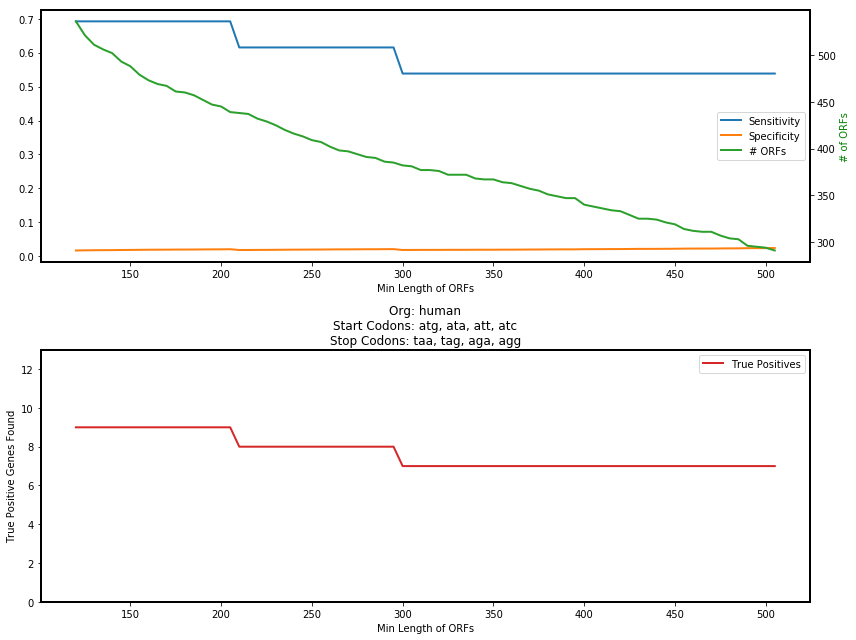



Varying Minimum ORF GC Content




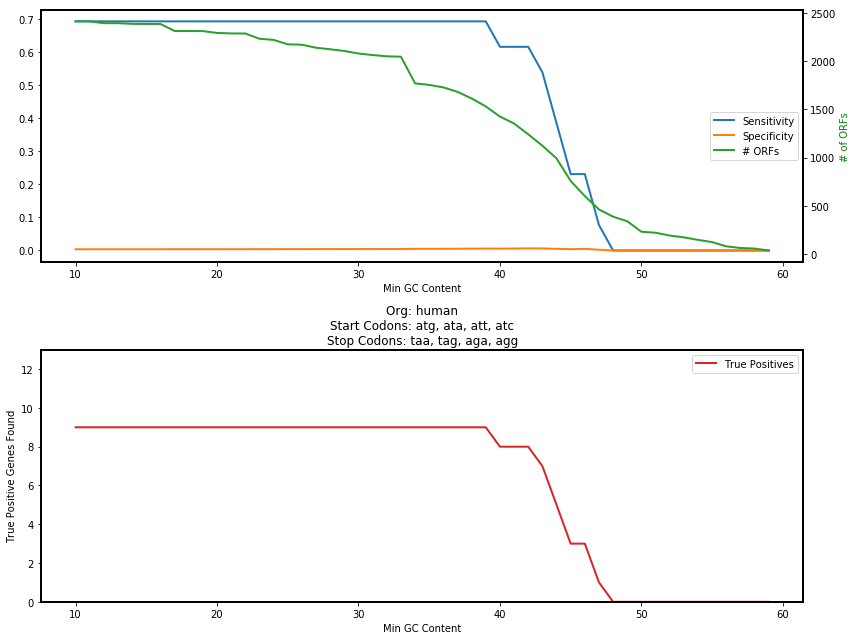



Varying Minimum Codon Usage Bias Value




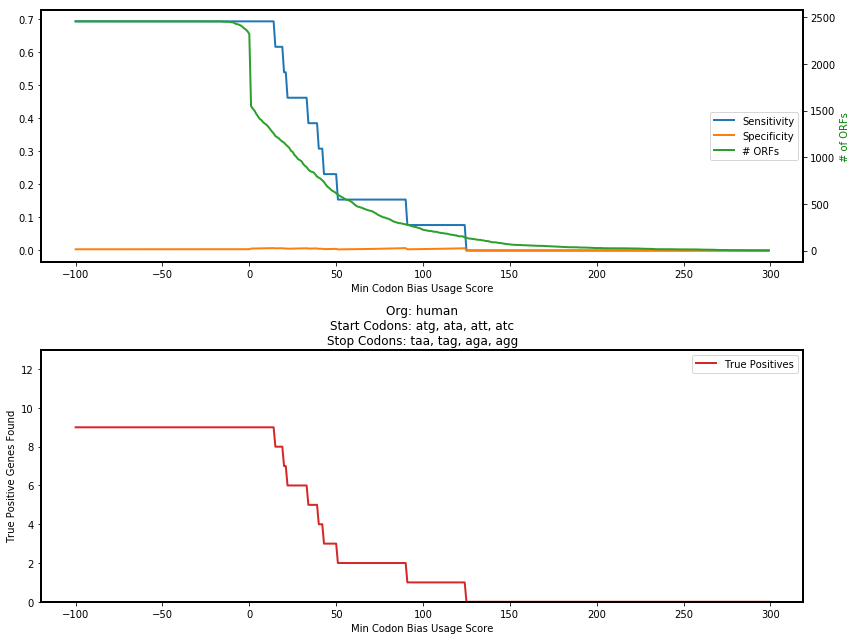

Filter(s)             ORFs Discovered    Ensembl Genes    True Pos    Sensitivity    Specificity    False Pos       FDR
------------------  -----------------  ---------------  ----------  -------------  -------------  -----------  --------
None                             2455               13           9      0.692308      0.00366599         2446  0.996334
Length >= 120                     536               13           9      0.692308      0.016791            527  0.983209
Length >= 125                     521               13           9      0.692308      0.0172745           512  0.982726
Length >= 130                     511               13           9      0.692308      0.0176125           502  0.982387
Length >= 135                     506               13           9      0.692308      0.0177866           497  0.982213
Length >= 140                     502               13           9      0.692308      0.0179283           493  0.982072
Length >= 145                     493   

In [314]:
# our seq vars that will hold seqs once read in from file
hum_seq = read_seq_fasta(human_file)

hum_genes = []

# forward strand
hum_orfs = findORFs(hum_seq, vert_mt_starts, vert_mt_stops)

# Human
for i in hum_orfs:
    ind = hum_seq.find(i)
    # genes will hold a tuple with direction indicator (1, -1), start index
    # end index, and the sequence.
    hum_genes.append(('1', ind +1, ind + len(i), len(i), i))


# reverse complement strand
hum_comp = rev_comp(hum_seq)
hum_comp_orfs = findORFs(hum_comp, vert_mt_starts, vert_mt_stops)


# Human
for i in hum_comp_orfs:
    ind = hum_comp.find(i)
    # genes will hold a tuple with direction indicator (1, -1), start index
    # end index, and the sequence.
    hum_genes.append(('-1',
                  len(hum_seq) - (ind + len(i)) +1 ,
                  len(hum_seq) - (ind) ,
                  len(i),  i))


testing(hum_genes, vert_mt_starts, vert_mt_stops, "human"  )
#testing(hum_genes, default_starts, default_stops, "human"  )


***
## Mouse
***

Filter: The filters applied to obtain this result.
ORFs Discovered: The number of ORFs found in the input sequence after filtering.
Ensembl Genes: The number of genes idenified by Ensembl.
True Pos: The number of predicted ORFs matching genes identified by Ensembl.
TPR: True Positive Rate (# True Pos / Total condition Postive).
False Pos: The nukmber of predicted ORFs NOT in the genes identifed by Ensembl.
FDR: False disovery rate (# False Positives / (# False Positives + # True Positives).



Varying Minimum ORF Length




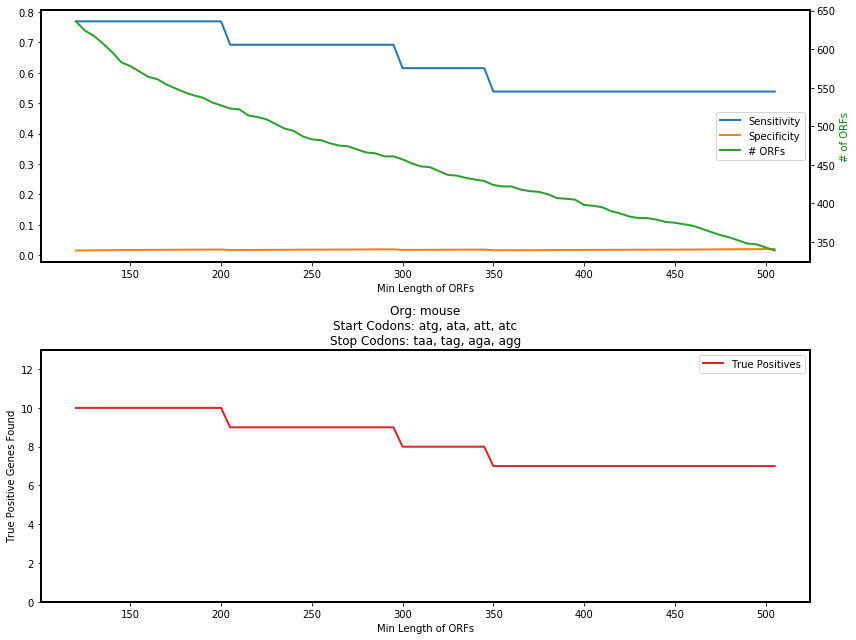



Varying Minimum ORF GC Content




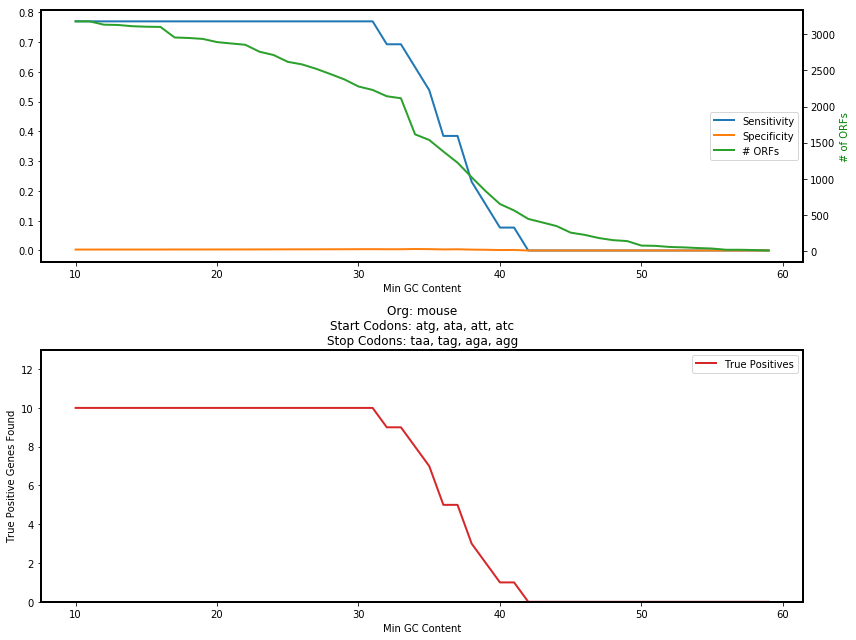



Varying Minimum Codon Usage Bias Value




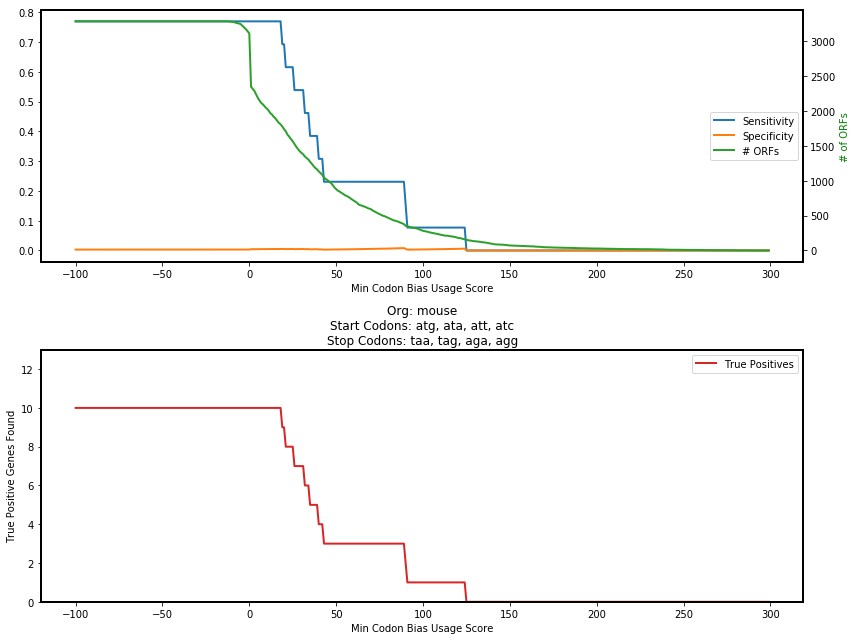

Filter(s)             ORFs Discovered    Ensembl Genes    True Pos    Sensitivity    Specificity    False Pos       FDR
------------------  -----------------  ---------------  ----------  -------------  -------------  -----------  --------
None                             3289               13          10      0.769231      0.00304044         3279  0.99696
Length >= 120                     636               13          10      0.769231      0.0157233           626  0.984277
Length >= 125                     624               13          10      0.769231      0.0160256           614  0.983974
Length >= 130                     617               13          10      0.769231      0.0162075           607  0.983793
Length >= 135                     607               13          10      0.769231      0.0164745           597  0.983526
Length >= 140                     596               13          10      0.769231      0.0167785           586  0.983221
Length >= 145                     583    

In [315]:
# our seq vars that will hold seqs once read in from file
mus_seq = read_seq_fasta(mouse_file)

mus_genes = []

# forward strand
mus_orfs = findORFs(mus_seq, vert_mt_starts, vert_mt_stops)


#Mouse
for i in mus_orfs:
    ind = mus_seq.find(i)
    # genes will hold a tuple with direction indicator (1, -1), start index
    # end index, and the sequence.
    mus_genes.append(('1', ind +1, ind + len(i), len(i), i))



# reverse complement strand
mus_comp = rev_comp(mus_seq)
mus_comp_orfs = findORFs(mus_comp, vert_mt_starts, vert_mt_stops)


# Mouse
for i in mus_comp_orfs:
    ind = mus_comp.find(i)
    # genes will hold a tuple with direction indicator (1, -1), start index
    # end index, and the sequence.
    mus_genes.append(('-1',
                  len(mus_seq) - (ind + len(i)) +1 ,
                  len(mus_seq) - (ind) ,
                  len(i),  i))





###################################################
#### We have our ORFs           let's test some ###
###         different filter params!            ###
###################################################

testing(mus_genes, vert_mt_starts, vert_mt_stops, "mouse")


## Final Human model
***

In [316]:
# our seq vars that will hold seqs once read in from file
hum_seq = read_seq_fasta(human_file)

hum_genes = []

# forward strand
hum_orfs = findORFs(hum_seq, vert_mt_starts, vert_mt_stops)

# Human
for i in hum_orfs:
    ind = hum_seq.find(i)
    # genes will hold a tuple with direction indicator (1, -1), start index
    # end index, and the sequence.
    hum_genes.append(('1', ind +1, ind + len(i), len(i), i))


# reverse complement strand
hum_comp = rev_comp(hum_seq)
hum_comp_orfs = findORFs(hum_comp, vert_mt_starts, vert_mt_stops)


# Human
for i in hum_comp_orfs:
    ind = hum_comp.find(i)
    # genes will hold a tuple with direction indicator (1, -1), start index
    # end index, and the sequence.
    hum_genes.append(('-1',
                  len(hum_seq) - (ind + len(i)) +1 ,
                  len(hum_seq) - (ind) ,
                  len(i),  i))


org = "human"
orfs = hum_genes
    
starts = vert_mt_starts
stops = vert_mt_stops
# Initial
tmp = check(orfs, org)
results = [('None', len(orfs), tmp[4], tmp[0], tmp[1], tmp[5], tmp[2], tmp[3])]




# Setup text for plots
organism = 'Org: ' + str(org)
start_codons = 'Start Codons: ' + ', '.join(starts)
stop_codons = 'Stop Codons: ' + ', '.join(stops)
text = organism + "\n" + start_codons + "\n" + stop_codons

orfs = len_filter(orfs, 200)
tmp = check(orfs, org)
filt = 'Length >= 200' 
results.append((filt,  len(orfs), tmp[4], tmp[0], tmp[1], tmp[5], tmp[2], tmp[3]))

orfs = gc_filter(orfs, 0.39)
tmp = check(orfs, org)
filt = 'GC Content > 0.39'
results.append((filt,  len(orfs), tmp[4], tmp[0], tmp[1], tmp[5], tmp[2], tmp[3]))

orfs = bias_score(orfs, 120, 1.4 )
tmp = check(orfs, org)
filt = 'Coding Bias > 1.4'
results.append((filt, len(orfs), tmp[4], tmp[0],  tmp[1],tmp[5], tmp[2], tmp[3]))




head = ['Filter(s)', 'ORFs Discovered', 'Ensembl Genes', 'True Pos','Sensitivity', 'Specificity',  'False Pos', 'FDR']
print(tab.tabulate(results, headers=head))





Filter(s)            ORFs Discovered    Ensembl Genes    True Pos    Sensitivity    Specificity    False Pos       FDR
-----------------  -----------------  ---------------  ----------  -------------  -------------  -----------  --------
None                            2455               13           9       0.692308     0.00366599         2446  0.996334
Length >= 200                    445               13           9       0.692308     0.0202247           436  0.979775
GC Content > 0.39                441               13           9       0.692308     0.0204082           432  0.979592
Coding Bias > 1.4                435               13           9       0.692308     0.0206897           426  0.97931


## Final Mouse model
***

In [319]:
# our seq vars that will hold seqs once read in from file
mus_seq = read_seq_fasta(mouse_file)

mus_genes = []

# forward strand
mus_orfs = findORFs(mus_seq, vert_mt_starts, vert_mt_stops)


#Mouse
for i in mus_orfs:
    ind = mus_seq.find(i)
    # genes will hold a tuple with direction indicator (1, -1), start index
    # end index, and the sequence.
    mus_genes.append(('1', ind +1, ind + len(i), len(i), i))



# reverse complement strand
mus_comp = rev_comp(mus_seq)
mus_comp_orfs = findORFs(mus_comp, vert_mt_starts, vert_mt_stops)


# Mouse
for i in mus_comp_orfs:
    ind = mus_comp.find(i)
    # genes will hold a tuple with direction indicator (1, -1), start index
    # end index, and the sequence.
    mus_genes.append(('-1',
                  len(mus_seq) - (ind + len(i)) +1 ,
                  len(mus_seq) - (ind) ,
                  len(i),  i))





org = "mouse"
orfs = mus_genes
    
starts = vert_mt_starts
stops = vert_mt_stops
# Initial
tmp = check(orfs, org)
results = [('None', len(orfs), tmp[4], tmp[0], tmp[1], tmp[5], tmp[2], tmp[3])]




# Setup text for plots
organism = 'Org: ' + str(org)
start_codons = 'Start Codons: ' + ', '.join(starts)
stop_codons = 'Stop Codons: ' + ', '.join(stops)
text = organism + "\n" + start_codons + "\n" + stop_codons

orfs = len_filter(orfs, 200)
tmp = check(orfs, org)
filt = 'Length >= 200' 
results.append((filt,  len(orfs), tmp[4], tmp[0], tmp[1], tmp[5], tmp[2], tmp[3]))

orfs = gc_filter(orfs, 0.31)
tmp = check(orfs, org)
filt = 'GC Content > 0.31'
results.append((filt,  len(orfs), tmp[4], tmp[0], tmp[1], tmp[5], tmp[2], tmp[3]))

orfs = bias_score(orfs, 120, 1.4 )
tmp = check(orfs, org)
filt = 'Coding Bias > 1.4'
results.append((filt, len(orfs), tmp[4], tmp[0],  tmp[1],tmp[5], tmp[2], tmp[3]))




head = ['Filter(s)', 'ORFs Discovered', 'Ensembl Genes', 'True Pos','Sensitivity', 'Specificity',  'False Pos', 'FDR']
print(tab.tabulate(results, headers=head))





Filter(s)            ORFs Discovered    Ensembl Genes    True Pos    Sensitivity    Specificity    False Pos       FDR
-----------------  -----------------  ---------------  ----------  -------------  -------------  -----------  --------
None                            3289               13          10       0.769231     0.00304044         3279  0.99696
Length >= 200                    527               13          10       0.769231     0.0189753           517  0.981025
GC Content > 0.31                525               13          10       0.769231     0.0190476           515  0.980952
Coding Bias > 1.4                525               13          10       0.769231     0.0190476           515  0.980952
